In [1]:
%matplotlib inline

In [2]:
!pip3 install spacy sklearn nltk > /dev/null
!python3 -m spacy download en_core_web_sm > /dev/null

In [3]:
import itertools as itt
from zipfile import ZipFile
from matplotlib import pyplot as plt
import tqdm
from collections import Counter
import numpy as np
from sklearn import linear_model, model_selection, metrics, cluster
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
nlp.add_pipe(nlp.create_pipe('sentencizer'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# reading labels
labels_dict = dict()
with open('case_reversed.csv') as f:
    next(f)  # header
    for line in f:
        caseId, label = line.strip().split(',')
        label = int(label)
        labels_dict[caseId] = label

In [5]:
# reading cases
with ZipFile('cases.zip') as casesZip:
    cases = []
    for name in itt.islice(casesZip.namelist(), 10000):  # built in to limit data to debug
        with casesZip.open(name) as f:
            year, caseId = name[:-len('.txt')].split('_')
            label = labels_dict[caseId]
            cases.append(dict(id=caseId, label=label, text=f.read().decode('utf-8').strip(), year=int(year)))

In [6]:
# parsing with spacy
for case in tqdm.tqdm(cases):
    case['nlp'] = nlp(case['text'])

100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


In [7]:
num_chars, num_words, num_sents = zip(*(
    (
        len(case['text']), 
        len(case['nlp']), 
        len(list(case['nlp'].sents))
    ) for case in cases))

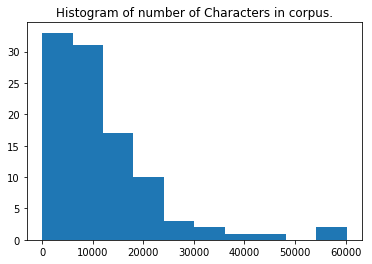

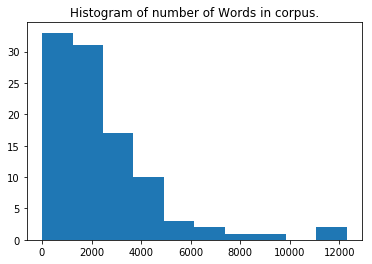

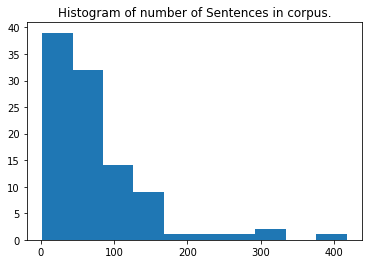

In [8]:
for name, freq in (
    ('Characters', num_chars),
    ('Words', num_words),
    ('Sentences', num_sents)
):
    plt.figure()
    plt.hist(freq)
    plt.title('Histogram of number of {} in corpus.'.format(name))
plt.show()

In [9]:
# get POS frequencies
data = []
for year, group in itt.groupby(sorted(cases, key=lambda c: c['year']), lambda c: c['year']):
    counters = [Counter(t.pos_ for t in case['nlp']) for case in group]
    data.append((year, sum(counters, Counter())))
years, counters = zip(*data)

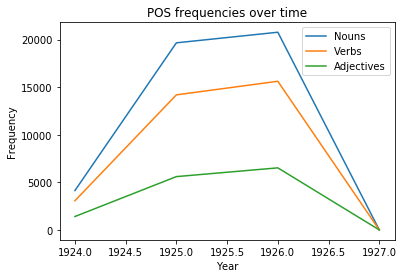

In [10]:
plt.figure()
for name, key in (
    ('Nouns', 'NOUN'),
    ('Verbs', 'VERB'),
    ('Adjectives', 'ADJ')
):
    plt.plot(years, [c[key] for c in counters], label=name)

plt.title('POS frequencies over time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

In [11]:
# removing punctuation and stop words
for case in cases:
    case['normal'] = [t for t in case['nlp'] 
                      if not (
                          t.pos_ == 'PUNCT' 
                          or t.is_stop
                          or len(t.text.strip()) == 0
                      )]

In [12]:
# parse trigrams ending in nouns
for case in cases:
    case['trigrams'] = []
    for t1, t2, t3 in zip(
        case['normal'][:-2],
        case['normal'][1:-1],
        case['normal'][2:]):
        if t3.pos_ == 'NOUN':
            case['trigrams'].append((t1.lemma, t2.lemma, t3.lemma))

# get 1000 most frequent ngrams
trigrams_voc = Counter(
    itt.chain.from_iterable(
        c['trigrams'] for c in cases
    )
).most_common(1000)

In [13]:
# create index table
trigram_to_idx = {t[0]: i for i, t in enumerate(trigrams_voc)}

In [14]:
# determine features of cases
for case in cases:
    case['features'] = [trigram_to_idx[t] 
                        for t in case['trigrams'] 
                        if t in trigram_to_idx]
            

In [15]:
# create data
data = np.zeros((len(cases), 1000))
labels = np.zeros(len(cases), np.int)
for idx, case in enumerate(cases):
    data[idx][case['features']] = 1.
    labels[idx] = case['label']

In [16]:
# make variance one
data /= np.std(data, axis=0)

In [17]:
data_train, data_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.1)

In [18]:
# create classifier
lr = linear_model.LogisticRegression(solver='liblinear')

In [19]:
# fit and predict
lr.fit(data_train, labels_train)
for name, X, Y in (
    ('Train', data_train, labels_train),
    ('Test', data_test, labels_test)
):
    pred = lr.predict(X)
    acc = metrics.accuracy_score(Y, pred)
    f1 = metrics.f1_score(Y, pred)
    print('{} Accuracy: {}'.format(name, acc))
    print('{} F1: {}'.format(name, f1))

Train Accuracy: 0.9666666666666667
Train F1: 0.9690721649484536
Test Accuracy: 0.6
Test F1: 0.7142857142857143


In [20]:
# grid search
param_grid = {
    'penalty': ('l1', 'l2'),
    'C': np.logspace(-2, 2, 20)
}
grid = model_selection.GridSearchCV(lr, param_grid, cv=5, return_train_score=False, iid=False)
grid.fit(data_train, labels_train)

print('Best parameters: {} (Score: {})'.format(grid.best_params_, grid.best_score_))

# get the best estimator
best_lr = grid.best_estimator_

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best parameters: {'C': 0.01, 'penalty': 'l1'} (Score: 0.4444444444444445)


In [21]:
# compute predictions
prob_train = best_lr.predict_proba(data_train)[:, 1]
prob_test = best_lr.predict_proba(data_test)[:, 1]

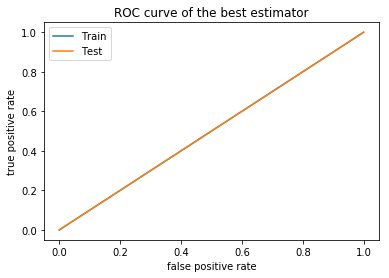

In [22]:
# compute roc curve
fpr_train, tpr_train, _ = metrics.roc_curve(labels_train, prob_train)
fpr_test, tpr_test, _ = metrics.roc_curve(labels_test, prob_test)
plt.figure()
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve of the best estimator')
plt.legend(loc='best')
plt.show()

In [23]:
# compute auc
auc_train = metrics.roc_auc_score(labels_train, prob_train)
auc_test = metrics.roc_auc_score(labels_test, prob_test)
print('ROC AUC Train: {}'.format(auc_train))
print('ROC AUC Test: {}'.format(auc_test))

ROC AUC Train: 0.5
ROC AUC Test: 0.5


In [24]:
# get all sentences
sentences = np.array(list(map(str, itt.chain.from_iterable(c['nlp'].sents for c in cases))))

In [25]:
# compute sentiments
sid = SentimentIntensityAnalyzer()
scored_sents = list(sorted((sid.polarity_scores(s)['compound'], s) for s in tqdm.tqdm(sentences)))


100%|██████████| 7178/7178 [00:02<00:00, 3179.47it/s]


In [26]:
print('LOWEST SENTIMENT SENTENCES:')
for sc, s in scored_sents[:10]:
    print(s)
    print('-----')

LOWEST SENTIMENT SENTENCES:

The evidence in the case is not before us, but from instructions of the court to the jury, not excepted to, enough appears to indicate that there was no abuse of legal process in lodging a charge of conspiracy against the plaintiffs in error, and that there was evidence tending to show a conspiracy to introduce into the country a large quantity of intoxicating liquors, and to possess and transport the same in violation of the law.
-----
291 , shows the rule which is: (a) The plea of nolo contendere is not applicable and, if tendered, cannot be accepted in a case where, under a statute, the punishment must be by imprisonment, with or without a fine; (b) but it is applicable, and, if tendered, may be accepted in a case where the punishment may be by fine alone, although the offense may as well be punishable by imprisonment; and (c) when so tendered and accepted the sentence may, in the court's discretion, prescribe both fine and imprisonment, or imprisonment 

In [27]:
print('HIGHEST SENTIMENT SENTENCES:')
for sc, s in reversed(scored_sents[-10:]):
    print(s)
    print('-----')

HIGHEST SENTIMENT SENTENCES:

The main grounds for recovery thereof, as stated in the petition, are: "That the assessment and collection of said additional income tax was erroneous and illegal in that it is based upon alleged income accruing to the plaintiff from the liquidating dividend upon the dissolution of the Osage Mercantile Company, a corporation, in which he was a stockholder; that this corporation was chartered and organized in the year 1902 with a capital stock of $15,000 divided into 150 shares of the par value of $100 each; that thereafter in the year 1906 the capital stock of said corporation was increased to $30,000 divided into 300 shares of the par value of $100 each; that on March 1, 1913, the plaintiff was the owner and holder of 112 shares of the capital stock in said corporation and the same was of the fair market value of $500 a share on said date; that on July 22, 1920, said corporation was liquidated and dissolved and its assets were transferred and distributed 

In [28]:
# compute tf-idf
vectorizer = TfidfVectorizer()
sent_tfidf = vectorizer.fit_transform(sentences)

In [29]:
# compute cosine-sim
cossim = metrics.pairwise.cosine_similarity(sent_tfidf, dense_output=False)

In [30]:
print('DISSIMILAR SENTENCES:')
min_inds = []
for _ in range(3):
    min_ind = np.unravel_index(cossim.argmin(), cossim.shape)
    print(sentences[min_ind[0]], sentences[min_ind[1]])
    cossim[min_ind] = 1
    cossim[min_ind[::-1]] = 1
    min_inds.append(min_ind)
for i in min_inds:
    cossim[i] = 0
    cossim[i[::-1]] = 0
cossim.setdiag(0)
print('SIMILAR SENTENCES:')
for _ in range(3):
    max_ind = np.unravel_index(cossim.argmax(), cossim.shape)
    print(sentences[max_ind[0]], sentences[max_ind[1]])
    cossim[max_ind] = 0
    cossim[max_ind[::-1]] = 0

DISSIMILAR SENTENCES:
ROSE , Circuit Judge. 
This is another sugar case.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  import sys


ROSE , Circuit Judge. 
This is another sugar case.
ROSE , Circuit Judge. 
This is another sugar case.
SIMILAR SENTENCES:


/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


DAVIS , Circuit Judge. DAVIS , Circuit Judge.
WALKER , Circuit Judge. WALKER , Circuit Judge.
WALKER , Circuit Judge. WALKER , Circuit Judge.


In [31]:
# k-means
num_clusters = 20
km = cluster.MiniBatchKMeans(num_clusters)
sent_labels = km.fit(sent_tfidf).labels_
for c in range(num_clusters):
    csents = sentences[sent_labels == c][:5]
    print('Sentences from cluster {}'.format(c))
    for s in csents:
        print(s)
    print('----------')

Sentences from cluster 0

The undersigned further agrees to pay any demurrage accruals under the tariff of the railway company, car days detention to be computed by subtracting the date of arrival of cars shipped for account of the undersigned from the date of release of equivalent cars.'"

Detention will be computed by subtracting the date of arrival of cars shipped from date of release of equivalent cars.
----------
Sentences from cluster 1

The questions in controversy in this case at the time of the hearing in the state court could only be moot and a finding by the state court upon these questions, even if authorized by the Legislature and specifically made in its judgment, would not in a federal court be binding upon the parties to this action.
----------
Sentences from cluster 2

Rep.
301 , 199 N. Y. S. 314 , reversed by the Appellate Division of the Supreme Court of New York for the First Department in June of this year, in an opinion which we have seen ( 210 App.

The Supreme C